Creating prices.csv

In [1]:
import pandas as pd
import numpy as np
import functools 

cad = pd.read_csv('USDCAD=X.csv')
mxn = pd.read_csv('MXN=X.csv')
jpy = pd.read_csv('JPY=X.csv')
sp500 = pd.read_csv('^GSPC.csv')

#keep close prices only, merge by date, rename columns
data = [cad[['Date','Close']], mxn[['Date','Close']], jpy[['Date','Close']], sp500[['Date','Close']]]
data = functools.reduce(lambda left,right: pd.merge(left,right,on=['Date'], how='outer'), data).dropna()
data.columns = ['Date', 'USD/CAD', 'USD/MXN', 'USD/JPY', 'S&P500']
#reverse the data for descending dates
data = data.iloc[::-1]

#X[t]=set of days t and three previous 
prices = data[data.columns[1:]] #closingPrices
X = pd.DataFrame(columns = ['USDCAD(t)','USDMXN(t)','USDJPY(t)','S&P500(t)',
                            'USDCAD(t-1)','USDMXN(t-1)','USDJPY(t-1)','S&P500(t-1)',
                            'USDCAD(t-2)','USDMXN(t-2)','USDJPY(t-2)','S&P500(t-2)',
                            'USDCAD(t-3)','USDMXN(t-3)','USDJPY(t-3)','S&P500(t-3)'])
for i in range(1, prices.shape[0]-4):
    X.loc[i-1] = tuple(prices[i:i+4].stack())
#add date and true price columns
X.insert(0, "Date", data['Date'][1:(prices.shape[0]-4)].reset_index(drop=True), True)
X['Y(t)'] = np.array(data['USD/JPY'][0:len(X)])
X.insert(0, "t", range(1,len(X)+1), True)
X.to_csv('prices.csv')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

prices = pd.read_csv('prices.csv')
X = prices[prices.columns[3:19]]
Xrescaled = preprocessing.StandardScaler().fit_transform(X) #rescale
pca = PCA(n_components=16)
pca.fit_transform(Xrescaled)
pve = pca.explained_variance_ratio_.cumsum()
h95 = np.where(pve>=0.95)[0][0]+1

#split train/test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xrescaled, np.array(prices['Y(t)']), test_size=0.20, random_state=0)

Finding best h

h= 4: 
best_val_loss=3.2890


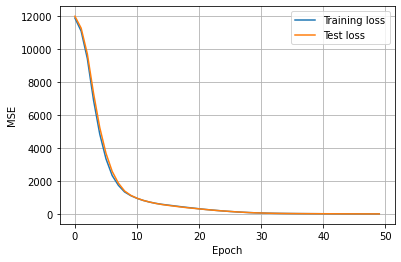

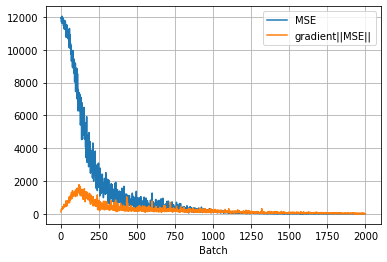

h= 21: 
best_val_loss=0.9579


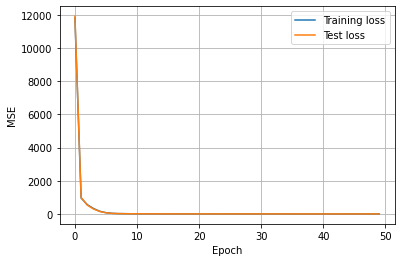

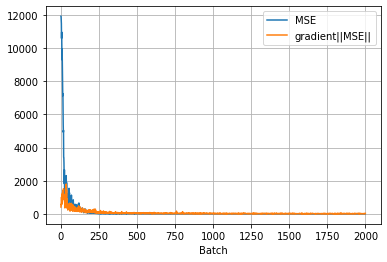

h= 37: 
best_val_loss=0.8175


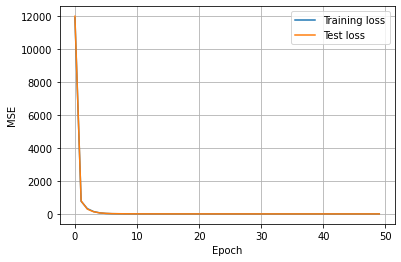

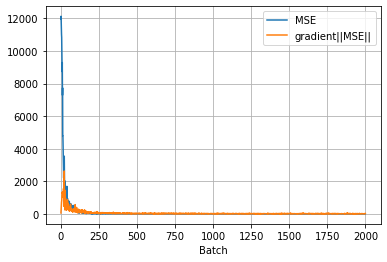

h= 54: 
best_val_loss=0.7742


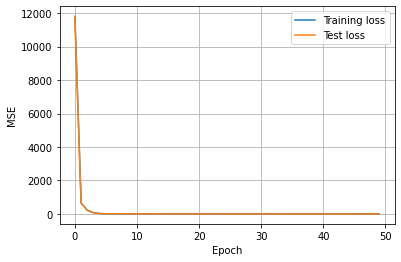

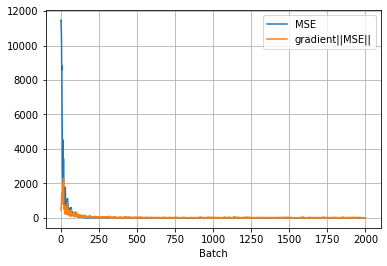

In [3]:
import tensorflow as tf
from tensorflow.keras import losses, optimizers, callbacks
from tensorflow.keras.models import load_model
tf.get_logger().setLevel('ERROR') #surpress logging 

train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(25)

loss_fn = losses.MeanSquaredError()
optimizer=optimizers.Adam(learning_rate=0.01)

hmax = int(np.floor((Xtrain.shape[0]-1)/18)) #18h+1<=trainingCases
h = np.round(np.linspace(h95, hmax, 4))

for i in h: #find best h
  model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(i, activation='relu', input_shape=(16,)),
  tf.keras.layers.Dense(1, activation='relu')])
  model.compile(optimizer=optimizer, loss=loss_fn)

  batch_loss = []; gradsNorm = []; epoch_loss = []; val_loss = []
  best_val_loss = model.evaluate(Xtest,Ytest,verbose=0)
  #tune `epochs` according to your data
  epochs = 50

  for epoch in range(epochs):
    #print("\nStart of epoch %d" % (epoch,))
    #MSE losses for each epoch
    epoch_loss_value = model.evaluate(Xtrain,Ytrain,verbose=0)
    epoch_loss.append(epoch_loss_value)
    val_loss_value = model.evaluate(Xtest,Ytest,verbose=0)
    val_loss.append(val_loss_value)
    #print("epoch_loss: %.4f - val_loss:%.4f" %  (float(epoch_loss_value), float(val_loss_value) )    )

    #Batch to batch MSE and gradient||MSE||
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      with tf.GradientTape() as tape:
        y_batch_pred = model(x_batch_train, training=True)
        loss_value = loss_fn(y_batch_train,y_batch_pred)
      grads = tape.gradient(loss_value, model.trainable_weights)
      gradsNorm.append(   np.sqrt( sum( [ np.sum( np.square(g.numpy()))  for g in grads ] ) )  )
      batch_loss.append(loss_value.numpy())
      optimizer.apply_gradients( zip( grads,model.trainable_weights ) )
    if val_loss_value < best_val_loss: #update model
      best_val_loss=val_loss_value
      model.save('bestModel%d'%i)

  print('h= %d: \nbest_val_loss=%.4f'%(i,best_val_loss))
  #plot MSE on training/test sets
  plt.plot(epoch_loss, label='Training loss')
  plt.plot(val_loss, label='Test loss')
  plt.xlabel('Epoch'); plt.ylabel('MSE')
  plt.legend(); plt.grid(True); plt.show()

  #plot batch to batch evolution of best model
  plt.plot(batch_loss, label='MSE')
  plt.plot(gradsNorm, label='gradient||MSE||')
  plt.xlabel('Batch'); plt.legend(); plt.grid(True); plt.show()